In [1]:
%matplotlib inline
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt

def _dfs(graph, start):
    visited, stack = set(), [start]
    while stack:
        vertex = stack.pop()
        if vertex not in visited:
            visited.add(vertex)
            stack.extend(graph[vertex] - visited)
    return visited


def _make_graph(matrix):
    graph = {}
    xis, yis = matrix.shape

    for (xi, yi), value in np.ndenumerate(matrix):
        if value == 0:
            continue

        n = xi * yis + yi
        nlist = []

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                # 8-neighbors
                x = divmod(xi + dx, xis)[1]
                y = divmod(yi + dy, yis)[1]
                if matrix[x, y] == 1:
                    ndn = x * yis + y
                    nlist.append(ndn)

        graph[n] = set(nlist) - set([n])
    return graph

In [2]:
u = mda.Universe('PackingDefect1/TGglyc.gro', 'PackingDefect1/TGglyc.xtc')

[1, 5, 1, 15]


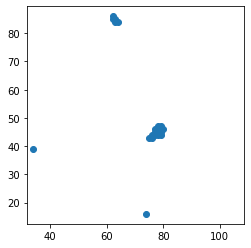

In [3]:
defects = []

u.trajectory[0]
ag = u.select_atoms('prop z > 0')
hz = np.average(ag.positions[:,2])
agup = u.select_atoms('prop z > %f' %hz)
agdw = u.select_atoms('prop z < %f' %hz)

plt.scatter(agup.positions[:,0], agup.positions[:,1])
plt.axis('square')

xarray = np.arange(0, u.dimensions[0], 1)
yarray = np.arange(0, u.dimensions[1], 1)
xx, yy = np.meshgrid(xarray, yarray)
Mup = np.zeros_like(xx)
Mdw = np.zeros_like(xx)

xind = agup.positions[:,0].astype(np.int64)
yind = agup.positions[:,1].astype(np.int64)

Mup[xind, yind] = 1

graph = _make_graph(Mup)
visited = set([])
for n in graph:
    if n not in visited:
        defect_loc = _dfs(graph, n)
        visited = visited.union(defect_loc)
        defects.append(len(defect_loc))
        
print(defects)

In [4]:
defects = []
for ts in u.trajectory:
    ag = u.select_atoms('prop z > 0')
    hz = np.average(ag.positions[:,2])
    agup = u.select_atoms('prop z > %f' %hz)
    agdw = u.select_atoms('prop z < %f' %hz)

    xarray = np.arange(0, u.dimensions[0], 1)
    yarray = np.arange(0, u.dimensions[1], 1)
    xx, yy = np.meshgrid(xarray, yarray)
    Mup = np.zeros_like(xx)
    Mdw = np.zeros_like(xx)
    
    
    ### UP
    xind = agup.positions[:,0].astype(np.int64)
    yind = agup.positions[:,1].astype(np.int64)
    Mup[xind, yind] = 1

    graph = _make_graph(Mup)
    visited = set([])
    for n in graph:
        if n not in visited:
            defect_loc = _dfs(graph, n)
            visited = visited.union(defect_loc)
            defects.append(len(defect_loc))
            
    
    ### DW  
    xind = agdw.positions[:,0].astype(np.int64)
    yind = agdw.positions[:,1].astype(np.int64)
    Mdw[xind, yind] = 1

    graph = _make_graph(Mdw)
    visited = set([])
    for n in graph:
        if n not in visited:
            defect_loc = _dfs(graph, n)
            visited = visited.union(defect_loc)
            defects.append(len(defect_loc))

print(defects)

[1, 5, 1, 15, 1, 1, 8, 8, 2, 2, 5, 24, 25, 4, 1, 1, 19, 11, 35, 45, 24]


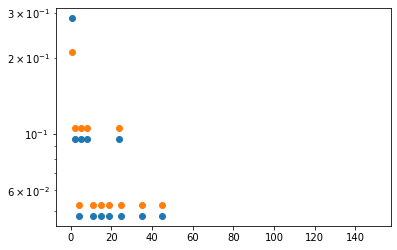

In [5]:
### HISTOGRAM
h, _ = np.histogram(defects, bins=np.linspace(0, 150, 600))
h[0] = 0
binp = 0.5 * (_[1:] + _[:-1])
plt.scatter(binp, h / np.sum(h))
plt.yscale('log')

d = np.loadtxt('PackingDefect1/TGglyc.dat')
plt.scatter(d[:,0], d[:,1])